# Comparison with other libraries

This notebooks extends 'evobandits_demo.ipynb' to compare the GMAB algorithm with popular alternatives.

Setup:

In [1]:
import json
from pathlib import Path

from evobandits import CategoricalParam, Study, GMAB
from irace import irace, Experiment, ParameterSpace, Scenario, Ordinal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from tqdm import tqdm

In [2]:
from application_example import genetic_algorithm

In [3]:
plt.style.use("default")

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = [
    "Computer Modern Roman",
    "Times New Roman",
    "Times",
    "DejaVu Serif",
]
mpl.rcParams["font.size"] = 14

## 1. Presets for the Optimization

Identical number of runs, budget and a seed for reproduction:

In [4]:
SEED = 42
N_RUNS = 50
SIM_BUDGET = 1000
EVAL_BUDGET = 500

All variables are modeled as ordinal variables from the ranges below to ensure identical search space.

In [5]:
POP_SIZE_RANGE = [i for i in range(50, 251, 1)]
GENERATIONS_RANGE = [100, 200, 300, 400, 500]
ELITE_SPLIT_RANGE = [i * 0.01 for i in range(21)]
TOURNAMENT_SPLIT_RANGE = [i * 0.01 for i in range(11)]
CROSSOVER_RATE_RANGE = [i * 0.01 for i in range(101)]
MUTATION_RATE_RANGE = [i * 0.01 for i in range(101)]

Size of the Search space

In [6]:
total_combinations = len(POP_SIZE_RANGE) * len(ELITE_SPLIT_RANGE) * len(GENERATIONS_RANGE) \
    * len(TOURNAMENT_SPLIT_RANGE) * len(CROSSOVER_RATE_RANGE) * len(MUTATION_RATE_RANGE)

print(f"Number of distinct solutions:\t{total_combinations:,}")

Number of distinct solutions:	2,368,213,155


## 2. Optimization

For each algorithm:
- Model the genetic_algorithm as objective function
- Model the search space
- Configure the algorithm
- Execute for preset, identical budget and runs
- Collect the results and re-sample to evaluate the "true" value of the configuration.

In [7]:
def estimate_true_value(seed, ga_configuration):
    evaluations = []
    rng = np.random.default_rng(seed)
    for _ in range(EVAL_BUDGET):
        seed_eval = rng.integers(0, 2**32 - 1, dtype=int)
        best_cost, _ = genetic_algorithm(seed=seed_eval, **ga_configuration)
        evaluations.append(best_cost)
    mean_evaluation = np.mean(evaluations)
    return mean_evaluation, evaluations

### 2.1 EvoBandits

In [8]:
def objective(seed: int, **params: dict):
    """Seeded, single-objective function to simulate the GA."""
    best_cost, _ = genetic_algorithm(seed=seed, **params)
    return best_cost

params = {
    "pop_size": CategoricalParam(POP_SIZE_RANGE),
    "generations": CategoricalParam(GENERATIONS_RANGE),
    "elite_split": CategoricalParam(ELITE_SPLIT_RANGE), 
    "tournament_split": CategoricalParam(TOURNAMENT_SPLIT_RANGE),
    "mutation_rate": CategoricalParam(MUTATION_RATE_RANGE), 
    "crossover_rate": CategoricalParam(CROSSOVER_RATE_RANGE), 
}

print("\nRunning optimization ...")
results_evobandits = []

for run_id in tqdm(range(N_RUNS), desc="EvoBandits | Run"):
    seed = SEED + run_id
    gmab = GMAB(population_size=10)
    study = Study(seed=seed, algorithm=gmab)
    study.optimize(objective, params, n_trials=SIM_BUDGET)
    print(f"Config:\t{study.best_params}")
    print(f"Value:\t{study.best_value}")

    mean_evaluation, evaluations = estimate_true_value(seed, study.best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_evobandits.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_solution": study.best_solution,
        "seed": seed
    })

    with open(Path("_data/04_results_evobandits.json"), 'w') as f:
        json.dump(results_evobandits, f)


Running optimization ...


EvoBandits | Run:   0%|          | 0/50 [00:00<?, ?it/s]

Config:	{'pop_size': 226, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.05, 'mutation_rate': 0.78, 'crossover_rate': 0.0}
Value:	7.925576596461831


EvoBandits | Run:   2%|▏         | 1/50 [1:31:11<74:28:22, 5471.48s/it]

Est. true value:	8.009099365950854
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.04, 'mutation_rate': 0.84, 'crossover_rate': 0.0}
Value:	7.866737136573285


EvoBandits | Run:   4%|▍         | 2/50 [3:04:55<74:08:54, 5561.14s/it]

Est. true value:	7.985106184692074
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.16, 'tournament_split': 0.09, 'mutation_rate': 0.84, 'crossover_rate': 0.25}
Value:	7.9950112647249405


EvoBandits | Run:   6%|▌         | 3/50 [4:21:24<66:48:40, 5117.45s/it]

Est. true value:	8.111970052316993
Config:	{'pop_size': 240, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.05, 'mutation_rate': 0.79, 'crossover_rate': 0.0}
Value:	7.797543215107326


EvoBandits | Run:   8%|▊         | 4/50 [5:49:30<66:14:19, 5183.89s/it]

Est. true value:	7.987494340327031
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.05, 'mutation_rate': 0.88, 'crossover_rate': 0.02}
Value:	7.873475842560513


EvoBandits | Run:  10%|█         | 5/50 [7:25:36<67:25:24, 5393.88s/it]

Est. true value:	7.962507188256683
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.03, 'tournament_split': 0.1, 'mutation_rate': 0.8200000000000001, 'crossover_rate': 0.09}
Value:	7.926533679546161


EvoBandits | Run:  12%|█▏        | 6/50 [8:50:36<64:42:02, 5293.70s/it]

Est. true value:	8.014330661207499
Config:	{'pop_size': 246, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.09, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.0}
Value:	7.865673725781605


EvoBandits | Run:  14%|█▍        | 7/50 [10:20:52<63:42:30, 5333.74s/it]

Est. true value:	7.9471121037165195
Config:	{'pop_size': 249, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.08, 'mutation_rate': 0.64, 'crossover_rate': 0.1}
Value:	7.860782956726181


EvoBandits | Run:  16%|█▌        | 8/50 [11:53:36<63:04:53, 5406.98s/it]

Est. true value:	8.03600209409043
Config:	{'pop_size': 230, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.1, 'mutation_rate': 0.97, 'crossover_rate': 0.0}
Value:	7.801173563105813


EvoBandits | Run:  18%|█▊        | 9/50 [13:16:14<59:58:56, 5266.74s/it]

Est. true value:	7.927656322194829
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.51, 'crossover_rate': 0.08}
Value:	7.919504538713044


EvoBandits | Run:  20%|██        | 10/50 [14:50:55<59:56:23, 5394.58s/it]

Est. true value:	8.008776573938981
Config:	{'pop_size': 245, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.1, 'mutation_rate': 0.65, 'crossover_rate': 0.0}
Value:	7.877796473373995


EvoBandits | Run:  22%|██▏       | 11/50 [16:20:38<58:24:12, 5391.08s/it]

Est. true value:	8.012169910420436
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'mutation_rate': 0.53, 'crossover_rate': 0.18}
Value:	7.9870913710800835


EvoBandits | Run:  24%|██▍       | 12/50 [17:33:04<53:33:02, 5073.23s/it]

Est. true value:	8.118224861010377
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.04, 'mutation_rate': 0.87, 'crossover_rate': 0.0}
Value:	7.886763863887318


EvoBandits | Run:  26%|██▌       | 13/50 [19:12:18<54:53:04, 5340.12s/it]

Est. true value:	7.989813157168992
Config:	{'pop_size': 217, 'generations': 400, 'elite_split': 0.0, 'tournament_split': 0.08, 'mutation_rate': 0.68, 'crossover_rate': 0.02}
Value:	8.011979728394396


EvoBandits | Run:  28%|██▊       | 14/50 [20:21:33<49:49:12, 4982.02s/it]

Est. true value:	8.067574052541332
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'mutation_rate': 0.75, 'crossover_rate': 0.0}
Value:	7.824910948289569


EvoBandits | Run:  30%|███       | 15/50 [21:53:27<49:59:43, 5142.37s/it]

Est. true value:	7.9741605664183774
Config:	{'pop_size': 208, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.1, 'mutation_rate': 0.93, 'crossover_rate': 0.08}
Value:	7.848482230823225


EvoBandits | Run:  32%|███▏      | 16/50 [23:13:09<47:32:31, 5033.86s/it]

Est. true value:	7.9887860900549965
Config:	{'pop_size': 238, 'generations': 400, 'elite_split': 0.08, 'tournament_split': 0.09, 'mutation_rate': 0.74, 'crossover_rate': 0.0}
Value:	7.8270375503905925


EvoBandits | Run:  34%|███▍      | 17/50 [24:27:27<44:33:25, 4860.76s/it]

Est. true value:	8.040487346341546
Config:	{'pop_size': 244, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.07, 'mutation_rate': 0.85, 'crossover_rate': 0.02}
Value:	7.79025969877992


EvoBandits | Run:  36%|███▌      | 18/50 [25:53:32<44:01:13, 4952.31s/it]

Est. true value:	7.979860433199059
Config:	{'pop_size': 237, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.09, 'mutation_rate': 0.81, 'crossover_rate': 0.0}
Value:	7.83209337122758


EvoBandits | Run:  38%|███▊      | 19/50 [27:20:13<43:17:09, 5026.75s/it]

Est. true value:	7.9918696217563285
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.07, 'mutation_rate': 0.89, 'crossover_rate': 0.07}
Value:	7.788137505855329


EvoBandits | Run:  40%|████      | 20/50 [28:34:57<40:31:56, 4863.87s/it]

Est. true value:	8.008133743096735
Config:	{'pop_size': 204, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.09, 'mutation_rate': 0.78, 'crossover_rate': 0.0}
Value:	7.8830218710724775


EvoBandits | Run:  42%|████▏     | 21/50 [29:45:59<37:43:38, 4683.40s/it]

Est. true value:	7.992215678397155
Config:	{'pop_size': 230, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'mutation_rate': 0.77, 'crossover_rate': 0.12}
Value:	7.795488840494284


EvoBandits | Run:  44%|████▍     | 22/50 [31:21:30<38:52:14, 4997.65s/it]

Est. true value:	7.999035405321987
Config:	{'pop_size': 237, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.86, 'crossover_rate': 0.07}
Value:	7.882302257973967


EvoBandits | Run:  46%|████▌     | 23/50 [32:46:48<37:45:14, 5033.85s/it]

Est. true value:	7.998569049969694
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.07, 'mutation_rate': 0.87, 'crossover_rate': 0.1}
Value:	7.930990198829469


EvoBandits | Run:  48%|████▊     | 24/50 [34:23:42<38:02:46, 5267.94s/it]

Est. true value:	7.982644502521114
Config:	{'pop_size': 238, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.0}
Value:	7.862777287603436


EvoBandits | Run:  50%|█████     | 25/50 [35:50:05<36:24:20, 5242.41s/it]

Est. true value:	7.9898043437455675
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.08, 'mutation_rate': 0.74, 'crossover_rate': 0.24}
Value:	7.912733416385374


EvoBandits | Run:  52%|█████▏    | 26/50 [37:27:48<36:11:29, 5428.72s/it]

Est. true value:	8.01352651527818
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.05, 'mutation_rate': 0.58, 'crossover_rate': 0.0}
Value:	7.895665217083467


EvoBandits | Run:  54%|█████▍    | 27/50 [38:44:28<33:05:40, 5180.02s/it]

Est. true value:	8.036065454217574
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.1, 'mutation_rate': 1.0, 'crossover_rate': 0.02}
Value:	7.693996008983231


EvoBandits | Run:  56%|█████▌    | 28/50 [40:28:14<33:34:20, 5493.68s/it]

Est. true value:	7.882097418500807
Config:	{'pop_size': 195, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.09, 'mutation_rate': 0.9, 'crossover_rate': 0.04}
Value:	7.876510749387142


EvoBandits | Run:  58%|█████▊    | 29/50 [41:29:10<28:49:50, 4942.40s/it]

Est. true value:	7.989801381824106
Config:	{'pop_size': 223, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.75, 'crossover_rate': 0.07}
Value:	7.901679158250727


EvoBandits | Run:  60%|██████    | 30/50 [42:53:17<27:37:56, 4973.80s/it]

Est. true value:	8.009519578170192
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.08, 'mutation_rate': 0.98, 'crossover_rate': 0.02}
Value:	7.8910710093626495


EvoBandits | Run:  62%|██████▏   | 31/50 [44:37:19<28:15:31, 5354.31s/it]

Est. true value:	7.915831150860409
Config:	{'pop_size': 249, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.08, 'mutation_rate': 0.9500000000000001, 'crossover_rate': 0.07}
Value:	7.706146049468488


EvoBandits | Run:  64%|██████▍   | 32/50 [46:05:50<26:42:24, 5341.34s/it]

Est. true value:	7.962662545737854
Config:	{'pop_size': 232, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.05, 'mutation_rate': 0.84, 'crossover_rate': 0.0}
Value:	7.909073910116425


EvoBandits | Run:  66%|██████▌   | 33/50 [47:21:07<24:03:18, 5094.05s/it]

Est. true value:	7.986558219166682
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.06, 'mutation_rate': 0.76, 'crossover_rate': 0.05}
Value:	7.753453370360533


EvoBandits | Run:  68%|██████▊   | 34/50 [48:53:56<23:16:25, 5236.61s/it]

Est. true value:	7.981881924950611
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.04, 'mutation_rate': 0.7000000000000001, 'crossover_rate': 0.0}
Value:	7.938918175605826


EvoBandits | Run:  70%|███████   | 35/50 [50:30:43<22:31:52, 5407.50s/it]

Est. true value:	8.018775323236934
Config:	{'pop_size': 206, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'mutation_rate': 0.79, 'crossover_rate': 0.14}
Value:	7.911933194917084


EvoBandits | Run:  72%|███████▏  | 36/50 [51:46:38<20:02:06, 5151.90s/it]

Est. true value:	7.999369269702338
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.07, 'mutation_rate': 0.75, 'crossover_rate': 0.15}
Value:	7.8882286485359785


EvoBandits | Run:  74%|███████▍  | 37/50 [53:22:50<19:16:34, 5338.01s/it]

Est. true value:	7.985251880657744
Config:	{'pop_size': 239, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.1, 'mutation_rate': 0.98, 'crossover_rate': 0.24}
Value:	7.89336568764409


EvoBandits | Run:  76%|███████▌  | 38/50 [55:10:55<18:56:22, 5681.90s/it]

Est. true value:	7.968185634893144
Config:	{'pop_size': 225, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.06, 'mutation_rate': 0.81, 'crossover_rate': 0.08}
Value:	7.890599347778869


EvoBandits | Run:  78%|███████▊  | 39/50 [56:25:16<16:14:32, 5315.64s/it]

Est. true value:	7.987022223414517
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'mutation_rate': 0.8, 'crossover_rate': 0.0}
Value:	7.890026695976286


EvoBandits | Run:  80%|████████  | 40/50 [58:12:16<15:41:09, 5646.95s/it]

Est. true value:	7.974329877225645
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.2, 'tournament_split': 0.09, 'mutation_rate': 0.81, 'crossover_rate': 0.0}
Value:	7.927989017286298


EvoBandits | Run:  82%|████████▏ | 41/50 [59:24:02<13:06:43, 5244.86s/it]

Est. true value:	8.030080284244177
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.05, 'mutation_rate': 0.65, 'crossover_rate': 0.0}
Value:	7.875789725364237


EvoBandits | Run:  84%|████████▍ | 42/50 [60:57:01<11:52:40, 5345.01s/it]

Est. true value:	7.986542463409997
Config:	{'pop_size': 200, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.06, 'mutation_rate': 0.75, 'crossover_rate': 0.01}
Value:	7.85948347105605


EvoBandits | Run:  86%|████████▌ | 43/50 [62:03:52<9:36:52, 4944.68s/it] 

Est. true value:	8.036028811322327
Config:	{'pop_size': 229, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.08, 'mutation_rate': 0.63, 'crossover_rate': 0.06}
Value:	7.861662036496136


EvoBandits | Run:  88%|████████▊ | 44/50 [63:33:19<8:27:08, 5071.36s/it]

Est. true value:	8.020267742945215
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.9400000000000001, 'crossover_rate': 0.0}
Value:	7.846357529578726


EvoBandits | Run:  90%|█████████ | 45/50 [64:50:49<6:52:04, 4944.90s/it]

Est. true value:	7.982574206573523
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.09, 'mutation_rate': 0.54, 'crossover_rate': 0.01}
Value:	7.896837829998442


EvoBandits | Run:  92%|█████████▏| 46/50 [66:05:01<5:19:48, 4797.10s/it]

Est. true value:	8.03635308957322
Config:	{'pop_size': 232, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.07, 'mutation_rate': 0.54, 'crossover_rate': 0.04}
Value:	7.818947143584331


EvoBandits | Run:  94%|█████████▍| 47/50 [67:38:19<4:11:52, 5037.44s/it]

Est. true value:	8.03253549623815
Config:	{'pop_size': 250, 'generations': 400, 'elite_split': 0.11, 'tournament_split': 0.07, 'mutation_rate': 0.9500000000000001, 'crossover_rate': 0.0}
Value:	7.903605700234994


EvoBandits | Run:  96%|█████████▌| 48/50 [68:57:21<2:44:57, 4948.90s/it]

Est. true value:	8.059633556200282
Config:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'mutation_rate': 0.84, 'crossover_rate': 0.0}
Value:	7.8601310346791795


EvoBandits | Run:  98%|█████████▊| 49/50 [70:27:49<1:24:52, 5092.49s/it]

Est. true value:	7.984837240667651
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.08, 'mutation_rate': 0.8, 'crossover_rate': 0.13}
Value:	7.903063362310793


EvoBandits | Run: 100%|██████████| 50/50 [71:51:50<00:00, 5174.22s/it]  

Est. true value:	7.997906602060502


### 2.2 Random Sampling

In [9]:
def randomize_configuration(seed):
    rng = np.random.default_rng(seed)
    return {
        "pop_size": int(rng.choice(POP_SIZE_RANGE)),
        "generations": int(rng.choice(GENERATIONS_RANGE)),
        "elite_split": float(rng.choice(ELITE_SPLIT_RANGE)),
        "tournament_split": float(rng.choice(TOURNAMENT_SPLIT_RANGE)),
        "crossover_rate": float(rng.choice(CROSSOVER_RATE_RANGE)),
        "mutation_rate": float(rng.choice(MUTATION_RATE_RANGE)),
    }

In [10]:
def random_search(budget, seed):
    # Evaluate the GA with random configurations
    random_search_results = {}
    rng = np.random.default_rng(seed)
    for _ in range(budget):
        seed = rng.integers(0, 2**32 - 1, dtype=int)
        rnd_config = randomize_configuration(seed)
        cost, _ = genetic_algorithm(seed=seed, **rnd_config)
        random_search_results[cost] = rnd_config

    # Find the config with the lowest cost
    best_value = min(random_search_results.keys())
    best_config = random_search_results[best_value]
    return best_value, best_config

In [11]:
results_rnd_search = []

for run_id in tqdm(range(N_RUNS), desc="RandomSearch | Run"):
    print("\nRunning optimization ...")
    seed = SEED + run_id
    best_value, best_params = random_search(SIM_BUDGET, seed)
    print(f"Config:\t{best_params}")
    print(f"Value:\t{best_value}")

    mean_evaluation, evaluations = estimate_true_value(seed, best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_rnd_search.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_value": best_value,
        "best_params": best_params,
        "seed": seed,
    })

    with open(Path("_data/04_results_rnd_search.json"), 'w') as f:
        json.dump(results_rnd_search, f)

RandomSearch | Run:   0%|          | 0/50 [00:00<?, ?it/s]


Running optimization ...
Config:	{'pop_size': 197, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.08, 'crossover_rate': 0.11, 'mutation_rate': 0.77}
Value:	7.897292467219535


RandomSearch | Run:   2%|▏         | 1/50 [49:27<40:23:51, 2968.00s/it]

Est. true value:	8.013481400974282

Running optimization ...
Config:	{'pop_size': 205, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.04, 'crossover_rate': 0.0, 'mutation_rate': 0.63}
Value:	7.647032600130154


RandomSearch | Run:   4%|▍         | 2/50 [1:37:05<38:42:25, 2903.03s/it]

Est. true value:	8.101609456558677

Running optimization ...
Config:	{'pop_size': 188, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.09, 'crossover_rate': 0.05, 'mutation_rate': 0.96}
Value:	7.515688249354553


RandomSearch | Run:   6%|▌         | 3/50 [2:22:38<36:53:02, 2825.16s/it]

Est. true value:	8.00753917565616

Running optimization ...
Config:	{'pop_size': 204, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.07, 'crossover_rate': 0.14, 'mutation_rate': 0.9500000000000001}
Value:	7.512806558713875


RandomSearch | Run:   8%|▊         | 4/50 [3:11:44<36:42:33, 2872.91s/it]

Est. true value:	8.088827235358147

Running optimization ...
Config:	{'pop_size': 246, 'generations': 400, 'elite_split': 0.1, 'tournament_split': 0.09, 'crossover_rate': 0.17, 'mutation_rate': 0.61}
Value:	7.5338538509292


RandomSearch | Run:  10%|█         | 5/50 [4:01:38<36:27:36, 2916.80s/it]

Est. true value:	8.132801534142395

Running optimization ...
Config:	{'pop_size': 143, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.1, 'crossover_rate': 0.28, 'mutation_rate': 0.86}
Value:	7.762740050307456


RandomSearch | Run:  12%|█▏        | 6/50 [4:39:49<33:02:47, 2703.81s/it]

Est. true value:	8.320205288729984

Running optimization ...
Config:	{'pop_size': 232, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'crossover_rate': 0.03, 'mutation_rate': 0.67}
Value:	7.621378014250823


RandomSearch | Run:  14%|█▍        | 7/50 [5:33:15<34:15:21, 2867.95s/it]

Est. true value:	8.013742401620165

Running optimization ...
Config:	{'pop_size': 225, 'generations': 400, 'elite_split': 0.02, 'tournament_split': 0.09, 'crossover_rate': 0.26, 'mutation_rate': 0.96}
Value:	7.823901227602012


RandomSearch | Run:  16%|█▌        | 8/50 [6:26:09<34:35:50, 2965.49s/it]

Est. true value:	8.264314568507817

Running optimization ...
Config:	{'pop_size': 190, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.06, 'crossover_rate': 0.19, 'mutation_rate': 0.89}
Value:	7.653820127736954


RandomSearch | Run:  18%|█▊        | 9/50 [7:13:26<33:19:06, 2925.52s/it]

Est. true value:	8.162474891027761

Running optimization ...
Config:	{'pop_size': 207, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.07, 'crossover_rate': 0.21, 'mutation_rate': 0.73}
Value:	7.5400095108834675


RandomSearch | Run:  20%|██        | 10/50 [8:02:53<32:38:48, 2938.21s/it]

Est. true value:	8.101597367786068

Running optimization ...
Config:	{'pop_size': 191, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.07, 'crossover_rate': 0.24, 'mutation_rate': 0.66}
Value:	7.571377535758199


RandomSearch | Run:  22%|██▏       | 11/50 [8:51:38<31:47:09, 2934.10s/it]

Est. true value:	8.128908918247106

Running optimization ...
Config:	{'pop_size': 230, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.06, 'crossover_rate': 0.08, 'mutation_rate': 0.89}
Value:	7.794341631741463


RandomSearch | Run:  24%|██▍       | 12/50 [9:46:57<32:12:25, 3051.19s/it]

Est. true value:	7.987662094178943

Running optimization ...
Config:	{'pop_size': 221, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.07, 'crossover_rate': 0.05, 'mutation_rate': 0.9500000000000001}
Value:	7.702583768288929


RandomSearch | Run:  26%|██▌       | 13/50 [10:38:41<31:31:22, 3067.11s/it]

Est. true value:	7.979437038643099

Running optimization ...
Config:	{'pop_size': 207, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.09, 'crossover_rate': 0.09, 'mutation_rate': 0.42}
Value:	7.786594192126253


RandomSearch | Run:  28%|██▊       | 14/50 [11:27:49<30:18:40, 3031.13s/it]

Est. true value:	8.136810331083533

Running optimization ...
Config:	{'pop_size': 161, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.09, 'crossover_rate': 0.04, 'mutation_rate': 0.62}
Value:	7.631457183538227


RandomSearch | Run:  30%|███       | 15/50 [12:08:48<27:47:36, 2858.75s/it]

Est. true value:	8.1147314850924

Running optimization ...
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.1, 'crossover_rate': 0.19, 'mutation_rate': 0.85}
Value:	7.669169581974357


RandomSearch | Run:  32%|███▏      | 16/50 [13:07:21<28:51:33, 3055.69s/it]

Est. true value:	7.998153929857648

Running optimization ...
Config:	{'pop_size': 249, 'generations': 400, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.46, 'mutation_rate': 0.68}
Value:	7.762481241922007


RandomSearch | Run:  34%|███▍      | 17/50 [14:04:29<29:02:12, 3167.67s/it]

Est. true value:	8.230971335047387

Running optimization ...
Config:	{'pop_size': 187, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.1, 'crossover_rate': 0.08, 'mutation_rate': 0.88}
Value:	7.69521648983677


RandomSearch | Run:  36%|███▌      | 18/50 [14:48:50<26:48:09, 3015.31s/it]

Est. true value:	8.016035184150663

Running optimization ...
Config:	{'pop_size': 206, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'crossover_rate': 0.09, 'mutation_rate': 0.77}
Value:	7.638983262082513


RandomSearch | Run:  38%|███▊      | 19/50 [15:35:53<25:28:05, 2957.60s/it]

Est. true value:	8.056674865914593

Running optimization ...
Config:	{'pop_size': 226, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.07, 'crossover_rate': 0.07, 'mutation_rate': 0.59}
Value:	7.732271237725183


RandomSearch | Run:  40%|████      | 20/50 [16:29:34<25:18:17, 3036.60s/it]

Est. true value:	8.04134741741569

Running optimization ...
Config:	{'pop_size': 210, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.18, 'mutation_rate': 0.56}
Value:	7.5972675798964815


RandomSearch | Run:  42%|████▏     | 21/50 [17:21:52<24:42:30, 3067.27s/it]

Est. true value:	8.0675302271952

Running optimization ...
Config:	{'pop_size': 222, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.08, 'crossover_rate': 0.26, 'mutation_rate': 0.93}
Value:	7.685567088485629


RandomSearch | Run:  44%|████▍     | 22/50 [18:17:01<24:25:12, 3139.74s/it]

Est. true value:	8.050512009533424

Running optimization ...
Config:	{'pop_size': 215, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.1, 'crossover_rate': 0.32, 'mutation_rate': 0.7000000000000001}
Value:	7.733115774706891


RandomSearch | Run:  46%|████▌     | 23/50 [19:10:51<23:45:05, 3166.88s/it]

Est. true value:	8.055299916280148

Running optimization ...
Config:	{'pop_size': 237, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.09, 'crossover_rate': 0.35000000000000003, 'mutation_rate': 0.72}
Value:	7.577440780517152


RandomSearch | Run:  48%|████▊     | 24/50 [20:06:42<23:16:16, 3222.18s/it]

Est. true value:	8.095088377808255

Running optimization ...
Config:	{'pop_size': 204, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.06, 'crossover_rate': 0.1, 'mutation_rate': 0.8200000000000001}
Value:	7.581797821538929


RandomSearch | Run:  50%|█████     | 25/50 [20:56:30<21:53:11, 3151.67s/it]

Est. true value:	8.007149827191785

Running optimization ...
Config:	{'pop_size': 189, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.07, 'crossover_rate': 0.01, 'mutation_rate': 0.75}
Value:	7.558502917333957


RandomSearch | Run:  52%|█████▏    | 26/50 [21:39:34<19:52:37, 2981.55s/it]

Est. true value:	8.038756189912908

Running optimization ...
Config:	{'pop_size': 240, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.07, 'crossover_rate': 0.33, 'mutation_rate': 0.54}
Value:	7.872488616254106


RandomSearch | Run:  54%|█████▍    | 27/50 [22:41:21<20:26:18, 3199.05s/it]

Est. true value:	8.098434684884696

Running optimization ...
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'crossover_rate': 0.05, 'mutation_rate': 0.84}
Value:	7.505650835234245


RandomSearch | Run:  56%|█████▌    | 28/50 [23:42:43<20:26:06, 3343.91s/it]

Est. true value:	7.9780851056795665

Running optimization ...
Config:	{'pop_size': 221, 'generations': 400, 'elite_split': 0.13, 'tournament_split': 0.08, 'crossover_rate': 0.06, 'mutation_rate': 0.87}
Value:	7.712069478103694


RandomSearch | Run:  58%|█████▊    | 29/50 [24:28:58<18:30:42, 3173.43s/it]

Est. true value:	8.082008569250227

Running optimization ...
Config:	{'pop_size': 243, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.06, 'crossover_rate': 0.11, 'mutation_rate': 0.75}
Value:	7.754199764735092


RandomSearch | Run:  60%|██████    | 30/50 [25:22:00<17:38:41, 3176.05s/it]

Est. true value:	8.041308834854927

Running optimization ...
Config:	{'pop_size': 240, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.07, 'mutation_rate': 0.5700000000000001}
Value:	7.598865851791532


RandomSearch | Run:  62%|██████▏   | 31/50 [26:18:58<17:08:42, 3248.56s/it]

Est. true value:	8.02600163113997

Running optimization ...
Config:	{'pop_size': 190, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.08, 'crossover_rate': 0.24, 'mutation_rate': 0.88}
Value:	7.805847708834681


RandomSearch | Run:  64%|██████▍   | 32/50 [27:10:26<16:00:03, 3200.18s/it]

Est. true value:	8.05691586739724

Running optimization ...
Config:	{'pop_size': 193, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.07, 'crossover_rate': 0.11, 'mutation_rate': 0.61}
Value:	7.726370190418541


RandomSearch | Run:  66%|██████▌   | 33/50 [27:56:54<14:31:42, 3076.63s/it]

Est. true value:	8.096239366715217

Running optimization ...
Config:	{'pop_size': 202, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.1, 'crossover_rate': 0.34, 'mutation_rate': 0.8}
Value:	7.636569386850606


RandomSearch | Run:  68%|██████▊   | 34/50 [28:47:18<13:36:14, 3060.89s/it]

Est. true value:	8.086270870025423

Running optimization ...
Config:	{'pop_size': 181, 'generations': 400, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.28, 'mutation_rate': 0.76}
Value:	7.449228235060069


RandomSearch | Run:  70%|███████   | 35/50 [29:30:16<12:08:59, 2915.94s/it]

Est. true value:	8.295345621908844

Running optimization ...
Config:	{'pop_size': 162, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.07, 'crossover_rate': 0.22, 'mutation_rate': 0.87}
Value:	7.6586169632473435


RandomSearch | Run:  72%|███████▏  | 36/50 [30:11:38<10:50:01, 2785.79s/it]

Est. true value:	8.274643661517892

Running optimization ...
Config:	{'pop_size': 214, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.09, 'crossover_rate': 0.23, 'mutation_rate': 0.52}
Value:	7.935368672512498


RandomSearch | Run:  74%|███████▍  | 37/50 [31:03:42<10:25:34, 2887.29s/it]

Est. true value:	8.095600214641223

Running optimization ...
Config:	{'pop_size': 248, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.07, 'crossover_rate': 0.29, 'mutation_rate': 0.81}
Value:	7.627231132692144


RandomSearch | Run:  76%|███████▌  | 38/50 [32:08:47<10:38:31, 3192.60s/it]

Est. true value:	7.996495292599669

Running optimization ...
Config:	{'pop_size': 230, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.1, 'crossover_rate': 0.16, 'mutation_rate': 0.64}
Value:	7.687731670549774


RandomSearch | Run:  78%|███████▊  | 39/50 [33:02:26<9:46:45, 3200.54s/it] 

Est. true value:	8.035792751069623

Running optimization ...
Config:	{'pop_size': 209, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.1, 'crossover_rate': 0.07, 'mutation_rate': 0.32}
Value:	7.7345858072871305


RandomSearch | Run:  80%|████████  | 40/50 [33:48:39<8:32:01, 3072.17s/it]

Est. true value:	8.322686647544002

Running optimization ...
Config:	{'pop_size': 238, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.05, 'crossover_rate': 0.38, 'mutation_rate': 0.84}
Value:	7.52741488106017


RandomSearch | Run:  82%|████████▏ | 41/50 [34:49:20<8:06:26, 3242.90s/it]

Est. true value:	8.18752403645461

Running optimization ...
Config:	{'pop_size': 194, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.08, 'crossover_rate': 0.01, 'mutation_rate': 0.74}
Value:	7.632048218837139


RandomSearch | Run:  84%|████████▍ | 42/50 [35:35:16<6:52:53, 3096.71s/it]

Est. true value:	8.021079111740603

Running optimization ...
Config:	{'pop_size': 234, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.1, 'crossover_rate': 0.28, 'mutation_rate': 0.74}
Value:	7.705366557614235


RandomSearch | Run:  86%|████████▌ | 43/50 [36:37:12<6:22:59, 3282.78s/it]

Est. true value:	8.030966362556066

Running optimization ...
Config:	{'pop_size': 247, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.07, 'crossover_rate': 0.5700000000000001, 'mutation_rate': 0.72}
Value:	7.775720333453791


RandomSearch | Run:  88%|████████▊ | 44/50 [37:45:13<5:52:12, 3522.01s/it]

Est. true value:	8.21787625683128

Running optimization ...
Config:	{'pop_size': 244, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.09, 'crossover_rate': 0.35000000000000003, 'mutation_rate': 0.88}
Value:	7.7296216756408


RandomSearch | Run:  90%|█████████ | 45/50 [38:49:17<5:01:33, 3618.66s/it]

Est. true value:	8.000410195510867

Running optimization ...
Config:	{'pop_size': 202, 'generations': 400, 'elite_split': 0.14, 'tournament_split': 0.1, 'crossover_rate': 0.0, 'mutation_rate': 0.44}
Value:	7.551247808218215


RandomSearch | Run:  92%|█████████▏| 46/50 [39:28:58<3:36:29, 3247.35s/it]

Est. true value:	8.403241226893533

Running optimization ...
Config:	{'pop_size': 201, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.08, 'crossover_rate': 0.15, 'mutation_rate': 0.79}
Value:	7.606396651281497


RandomSearch | Run:  94%|█████████▍| 47/50 [40:15:19<2:35:22, 3107.48s/it]

Est. true value:	8.073028814179194

Running optimization ...
Config:	{'pop_size': 207, 'generations': 500, 'elite_split': 0.17, 'tournament_split': 0.09, 'crossover_rate': 0.07, 'mutation_rate': 0.67}
Value:	7.470821333005951


RandomSearch | Run:  96%|█████████▌| 48/50 [41:02:46<1:40:58, 3029.30s/it]

Est. true value:	8.051018264258746

Running optimization ...
Config:	{'pop_size': 204, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.05, 'crossover_rate': 0.35000000000000003, 'mutation_rate': 0.92}
Value:	7.804598969666058


RandomSearch | Run:  98%|█████████▊| 49/50 [41:57:07<51:38, 3098.99s/it]  

Est. true value:	8.475073360705418

Running optimization ...
Config:	{'pop_size': 236, 'generations': 500, 'elite_split': 0.12, 'tournament_split': 0.06, 'crossover_rate': 0.2, 'mutation_rate': 0.87}
Value:	7.742618532247018


RandomSearch | Run: 100%|██████████| 50/50 [42:54:58<00:00, 3089.98s/it]

Est. true value:	8.009247303295435


### 2.3 IRACE

In [12]:
def ga_runner(experiment: Experiment, scenario: Scenario):
    """Seeded, single-objective function to simulate the GA with irace."""
    best_cost, _ = genetic_algorithm(
        seed=experiment.seed, **experiment.configuration
    )
    return float(best_cost)

param_space = ParameterSpace(
    [
        Ordinal("pop_size", POP_SIZE_RANGE),
        Ordinal("generations", GENERATIONS_RANGE),
        Ordinal("elite_split", ELITE_SPLIT_RANGE),
        Ordinal("tournament_split", TOURNAMENT_SPLIT_RANGE),
        Ordinal("crossover_rate", CROSSOVER_RATE_RANGE),
        Ordinal("mutation_rate", MUTATION_RATE_RANGE),
    ]
)

print("\nRunning optimization ...")
results_irace = []

for run_id in tqdm(range(N_RUNS), desc="IRACE | Run"):
    print("\nRunning optimization ...")
    seed = SEED + run_id
    scenario = Scenario(
        max_experiments=SIM_BUDGET,
        verbose=0,
    )
    best_params = irace(ga_runner, param_space, scenario)[0]
    print(f"Config:\t{best_params}")

    mean_evaluation, evaluations = estimate_true_value(seed, best_params)
    print(f"Est. true value:\t{mean_evaluation}")

    results_irace.append({
        "mean_evaluation": mean_evaluation,
        "evaluations": evaluations,
        "best_params": best_params,
        "seed": seed,
    })

    with open(Path("_data/04_results_irace.json"), 'w') as f:
        json.dump(results_irace, f)


Running optimization ...


IRACE | Run:   0%|          | 0/50 [00:00<?, ?it/s]


Running optimization ...


Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
c:\Users\fwuer\Code\evobandits-demo\.venv\Lib\site-packages\rpy2\rinterface\__init__.py:1211: UserWarning: Environment variable "PATH" redefined by R and overriding existing variable. Current: "c:\Users\fwuer\Code\evobandits-demo\.venv\Scripts;C:\Program Files (x86)\Intel\iCLS Client\;C:\Program Files\Intel\iCLS Client\;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files\Intel\WiFi\bin\;C:\Program Files\Common Files\Intel\WirelessCommon\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Users\fwuer\AppData\Local\Programs\Python\Launc

Config:	OrderedDict({'pop_size': 199, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.09, 'crossover_rate': 0.08, 'mutation_rate': 0.96})


IRACE | Run:   2%|▏         | 1/50 [57:38<47:04:17, 3458.32s/it]

Est. true value:	8.004072794238738

Running optimization ...
Config:	OrderedDict({'pop_size': 186, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.08, 'crossover_rate': 0.01, 'mutation_rate': 0.84})


IRACE | Run:   4%|▍         | 2/50 [1:48:37<42:59:02, 3223.79s/it]

Est. true value:	8.05216708562738

Running optimization ...
Config:	OrderedDict({'pop_size': 231, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'crossover_rate': 0.25, 'mutation_rate': 0.92})


IRACE | Run:   6%|▌         | 3/50 [2:56:48<47:15:16, 3619.51s/it]

Est. true value:	8.031273803417456

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.1, 'crossover_rate': 0.09, 'mutation_rate': 0.91})


IRACE | Run:   8%|▊         | 4/50 [4:13:47<51:17:29, 4014.13s/it]

Est. true value:	7.95148684778089

Running optimization ...
Config:	OrderedDict({'pop_size': 234, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.09, 'crossover_rate': 0.04, 'mutation_rate': 0.91})


IRACE | Run:  10%|█         | 5/50 [5:23:30<50:56:19, 4075.10s/it]

Est. true value:	7.99988265748262

Running optimization ...
Config:	OrderedDict({'pop_size': 246, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.1, 'crossover_rate': 0.02, 'mutation_rate': 0.42})


IRACE | Run:  12%|█▏        | 6/50 [6:27:43<48:52:59, 3999.54s/it]

Est. true value:	8.088061893715068

Running optimization ...
Config:	OrderedDict({'pop_size': 220, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'crossover_rate': 0.08, 'mutation_rate': 0.8})


IRACE | Run:  14%|█▍        | 7/50 [7:29:20<46:35:26, 3900.61s/it]

Est. true value:	8.00135788671384

Running optimization ...
Config:	OrderedDict({'pop_size': 224, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.1, 'crossover_rate': 0.31, 'mutation_rate': 0.9400000000000001})


IRACE | Run:  16%|█▌        | 8/50 [8:41:03<47:00:05, 4028.69s/it]

Est. true value:	8.018989347888024

Running optimization ...
Config:	OrderedDict({'pop_size': 189, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.1, 'crossover_rate': 0.04, 'mutation_rate': 0.37})


IRACE | Run:  18%|█▊        | 9/50 [9:32:28<42:31:22, 3733.71s/it]

Est. true value:	8.219177658881737

Running optimization ...
Config:	OrderedDict({'pop_size': 233, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.08, 'crossover_rate': 0.16, 'mutation_rate': 0.61})


IRACE | Run:  20%|██        | 10/50 [10:35:40<41:41:11, 3751.78s/it]

Est. true value:	8.02562543390154

Running optimization ...
Config:	OrderedDict({'pop_size': 185, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.08, 'crossover_rate': 0.16, 'mutation_rate': 0.55})


IRACE | Run:  22%|██▏       | 11/50 [11:28:29<38:42:36, 3573.25s/it]

Est. true value:	8.146476638833853

Running optimization ...
Config:	OrderedDict({'pop_size': 228, 'generations': 500, 'elite_split': 0.13, 'tournament_split': 0.1, 'crossover_rate': 0.0, 'mutation_rate': 1.0})


IRACE | Run:  24%|██▍       | 12/50 [12:31:42<38:25:33, 3640.35s/it]

Est. true value:	7.925083006492

Running optimization ...
Config:	OrderedDict({'pop_size': 178, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'crossover_rate': 0.11, 'mutation_rate': 0.92})


IRACE | Run:  26%|██▌       | 13/50 [13:31:58<37:20:15, 3632.85s/it]

Est. true value:	8.022344160410249

Running optimization ...
Config:	OrderedDict({'pop_size': 210, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.09, 'crossover_rate': 0.06, 'mutation_rate': 0.79})


IRACE | Run:  28%|██▊       | 14/50 [14:33:45<36:33:04, 3655.11s/it]

Est. true value:	7.999238230924029

Running optimization ...
Config:	OrderedDict({'pop_size': 244, 'generations': 500, 'elite_split': 0.2, 'tournament_split': 0.09, 'crossover_rate': 0.46, 'mutation_rate': 0.8})


IRACE | Run:  30%|███       | 15/50 [15:38:32<36:13:01, 3725.17s/it]

Est. true value:	8.11220870703789

Running optimization ...
Config:	OrderedDict({'pop_size': 241, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'crossover_rate': 0.25, 'mutation_rate': 0.66})


IRACE | Run:  32%|███▏      | 16/50 [16:53:41<37:24:33, 3960.98s/it]

Est. true value:	8.032221640211574

Running optimization ...
Config:	OrderedDict({'pop_size': 224, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.08, 'crossover_rate': 0.29, 'mutation_rate': 0.88})


IRACE | Run:  34%|███▍      | 17/50 [17:57:53<36:00:34, 3928.32s/it]

Est. true value:	8.056807736628278

Running optimization ...
Config:	OrderedDict({'pop_size': 242, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.09, 'crossover_rate': 0.08, 'mutation_rate': 0.8200000000000001})


IRACE | Run:  36%|███▌      | 18/50 [19:11:28<36:13:02, 4074.44s/it]

Est. true value:	7.970269184206076

Running optimization ...
Config:	OrderedDict({'pop_size': 133, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.02, 'mutation_rate': 0.62})


IRACE | Run:  38%|███▊      | 19/50 [19:53:23<31:03:09, 3606.13s/it]

Est. true value:	8.212965176667538

Running optimization ...
Config:	OrderedDict({'pop_size': 204, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.1, 'crossover_rate': 0.02, 'mutation_rate': 0.84})


IRACE | Run:  40%|████      | 20/50 [20:58:30<30:48:16, 3696.56s/it]

Est. true value:	8.034493228944035

Running optimization ...
Config:	OrderedDict({'pop_size': 233, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.07, 'crossover_rate': 0.1, 'mutation_rate': 0.64})


IRACE | Run:  42%|████▏     | 21/50 [22:03:07<30:12:52, 3750.76s/it]

Est. true value:	8.04800491992849

Running optimization ...
Config:	OrderedDict({'pop_size': 245, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'crossover_rate': 0.26, 'mutation_rate': 0.61})


IRACE | Run:  44%|████▍     | 22/50 [23:06:34<29:18:09, 3767.50s/it]

Est. true value:	8.093804689245776

Running optimization ...
Config:	OrderedDict({'pop_size': 205, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.05, 'crossover_rate': 0.11, 'mutation_rate': 0.56})


IRACE | Run:  46%|████▌     | 23/50 [24:04:02<27:32:15, 3671.70s/it]

Est. true value:	8.15480769408553

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.11, 'tournament_split': 0.09, 'crossover_rate': 0.39, 'mutation_rate': 0.6900000000000001})


IRACE | Run:  48%|████▊     | 24/50 [25:13:06<27:32:31, 3813.53s/it]

Est. true value:	8.093142637743231

Running optimization ...
Config:	OrderedDict({'pop_size': 246, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.1, 'crossover_rate': 0.13, 'mutation_rate': 0.91})


IRACE | Run:  50%|█████     | 25/50 [26:31:34<28:20:44, 4081.77s/it]

Est. true value:	7.959120308561875

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.09, 'crossover_rate': 0.31, 'mutation_rate': 0.6})


IRACE | Run:  52%|█████▏    | 26/50 [27:45:21<27:54:07, 4185.32s/it]

Est. true value:	8.020945330613724

Running optimization ...
Config:	OrderedDict({'pop_size': 242, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.08, 'crossover_rate': 0.3, 'mutation_rate': 0.79})


IRACE | Run:  54%|█████▍    | 27/50 [28:52:25<26:25:52, 4137.05s/it]

Est. true value:	8.03476531770876

Running optimization ...
Config:	OrderedDict({'pop_size': 215, 'generations': 400, 'elite_split': 0.04, 'tournament_split': 0.09, 'crossover_rate': 0.25, 'mutation_rate': 0.8})


IRACE | Run:  56%|█████▌    | 28/50 [29:52:23<24:17:31, 3975.08s/it]

Est. true value:	8.10211887030004

Running optimization ...
Config:	OrderedDict({'pop_size': 185, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.07, 'crossover_rate': 0.0, 'mutation_rate': 0.7000000000000001})


IRACE | Run:  58%|█████▊    | 29/50 [30:37:46<20:59:52, 3599.64s/it]

Est. true value:	8.220760958977527

Running optimization ...
Config:	OrderedDict({'pop_size': 226, 'generations': 400, 'elite_split': 0.05, 'tournament_split': 0.1, 'crossover_rate': 0.04, 'mutation_rate': 0.75})


IRACE | Run:  60%|██████    | 30/50 [31:44:41<20:41:25, 3724.27s/it]

Est. true value:	8.035112388112825

Running optimization ...
Config:	OrderedDict({'pop_size': 242, 'generations': 500, 'elite_split': 0.14, 'tournament_split': 0.1, 'crossover_rate': 0.04, 'mutation_rate': 0.51})


IRACE | Run:  62%|██████▏   | 31/50 [32:47:00<19:40:41, 3728.51s/it]

Est. true value:	8.053033151581516

Running optimization ...
Config:	OrderedDict({'pop_size': 217, 'generations': 500, 'elite_split': 0.19, 'tournament_split': 0.08, 'crossover_rate': 0.01, 'mutation_rate': 0.96})


IRACE | Run:  64%|██████▍   | 32/50 [33:44:16<18:12:16, 3640.93s/it]

Est. true value:	7.989648154340753

Running optimization ...
Config:	OrderedDict({'pop_size': 209, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.05, 'crossover_rate': 0.04, 'mutation_rate': 0.6})


IRACE | Run:  66%|██████▌   | 33/50 [34:40:36<16:49:25, 3562.69s/it]

Est. true value:	8.065507102499577

Running optimization ...
Config:	OrderedDict({'pop_size': 208, 'generations': 500, 'elite_split': 0.09, 'tournament_split': 0.05, 'crossover_rate': 0.14, 'mutation_rate': 0.64})


IRACE | Run:  68%|██████▊   | 34/50 [35:40:03<15:50:19, 3563.74s/it]

Est. true value:	8.09638228120826

Running optimization ...
Config:	OrderedDict({'pop_size': 210, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.08, 'crossover_rate': 0.09, 'mutation_rate': 0.88})


IRACE | Run:  70%|███████   | 35/50 [36:39:37<14:51:44, 3566.96s/it]

Est. true value:	8.001625860901022

Running optimization ...
Config:	OrderedDict({'pop_size': 245, 'generations': 500, 'elite_split': 0.08, 'tournament_split': 0.09, 'crossover_rate': 0.06, 'mutation_rate': 0.97})


IRACE | Run:  72%|███████▏  | 36/50 [37:50:40<14:41:01, 3775.81s/it]

Est. true value:	7.934491349269076

Running optimization ...
Config:	OrderedDict({'pop_size': 175, 'generations': 500, 'elite_split': 0.07, 'tournament_split': 0.05, 'crossover_rate': 0.01, 'mutation_rate': 0.62})


IRACE | Run:  74%|███████▍  | 37/50 [38:41:57<12:52:40, 3566.21s/it]

Est. true value:	8.15145161155712

Running optimization ...
Config:	OrderedDict({'pop_size': 249, 'generations': 500, 'elite_split': 0.0, 'tournament_split': 0.1, 'crossover_rate': 0.11, 'mutation_rate': 0.77})


IRACE | Run:  76%|███████▌  | 38/50 [39:51:07<12:28:14, 3741.20s/it]

Est. true value:	8.004513850519047

Running optimization ...
Config:	OrderedDict({'pop_size': 239, 'generations': 500, 'elite_split': 0.18, 'tournament_split': 0.06, 'crossover_rate': 0.02, 'mutation_rate': 0.72})


IRACE | Run:  78%|███████▊  | 39/50 [40:53:29<11:25:56, 3741.51s/it]

Est. true value:	8.037915890540077

Running optimization ...
Config:	OrderedDict({'pop_size': 241, 'generations': 500, 'elite_split': 0.05, 'tournament_split': 0.07, 'crossover_rate': 0.0, 'mutation_rate': 0.9500000000000001})


IRACE | Run:  80%|████████  | 40/50 [42:07:24<10:58:13, 3949.40s/it]

Est. true value:	7.943902812649728

Running optimization ...
Config:	OrderedDict({'pop_size': 191, 'generations': 400, 'elite_split': 0.01, 'tournament_split': 0.08, 'crossover_rate': 0.05, 'mutation_rate': 0.92})


IRACE | Run:  82%|████████▏ | 41/50 [42:58:01<9:11:23, 3675.92s/it] 

Est. true value:	8.290301870697556

Running optimization ...
Config:	OrderedDict({'pop_size': 177, 'generations': 500, 'elite_split': 0.03, 'tournament_split': 0.07, 'crossover_rate': 0.13, 'mutation_rate': 0.66})


IRACE | Run:  84%|████████▍ | 42/50 [43:51:36<7:51:39, 3537.49s/it]

Est. true value:	8.101417961374867

Running optimization ...
Config:	OrderedDict({'pop_size': 250, 'generations': 500, 'elite_split': 0.15, 'tournament_split': 0.06, 'crossover_rate': 0.07, 'mutation_rate': 0.53})


IRACE | Run:  86%|████████▌ | 43/50 [44:54:04<7:00:05, 3600.78s/it]

Est. true value:	8.078247392384155

Running optimization ...
Config:	OrderedDict({'pop_size': 248, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.07, 'crossover_rate': 0.1, 'mutation_rate': 0.75})


IRACE | Run:  88%|████████▊ | 44/50 [46:03:34<6:17:09, 3771.57s/it]

Est. true value:	7.998663814233399

Running optimization ...
Config:	OrderedDict({'pop_size': 246, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'crossover_rate': 0.14, 'mutation_rate': 0.99})


IRACE | Run:  90%|█████████ | 45/50 [47:11:41<5:22:10, 3866.04s/it]

Est. true value:	7.948886355389779

Running optimization ...
Config:	OrderedDict({'pop_size': 250, 'generations': 500, 'elite_split': 0.06, 'tournament_split': 0.09, 'crossover_rate': 0.26, 'mutation_rate': 0.88})


IRACE | Run:  92%|█████████▏| 46/50 [48:29:34<4:33:52, 4108.18s/it]

Est. true value:	7.979586614273034

Running optimization ...
Config:	OrderedDict({'pop_size': 249, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.05, 'crossover_rate': 0.21, 'mutation_rate': 0.64})


IRACE | Run:  94%|█████████▍| 47/50 [49:44:46<3:31:27, 4229.30s/it]

Est. true value:	8.044047815744674

Running optimization ...
Config:	OrderedDict({'pop_size': 218, 'generations': 500, 'elite_split': 0.01, 'tournament_split': 0.09, 'crossover_rate': 0.02, 'mutation_rate': 0.56})


IRACE | Run:  96%|█████████▌| 48/50 [50:49:14<2:17:21, 4120.88s/it]

Est. true value:	8.023503910994682

Running optimization ...
Config:	OrderedDict({'pop_size': 234, 'generations': 500, 'elite_split': 0.16, 'tournament_split': 0.07, 'crossover_rate': 0.09, 'mutation_rate': 0.79})


IRACE | Run:  98%|█████████▊| 49/50 [51:53:55<1:07:28, 4048.94s/it]

Est. true value:	8.000981283021197

Running optimization ...
Config:	OrderedDict({'pop_size': 228, 'generations': 500, 'elite_split': 0.1, 'tournament_split': 0.09, 'crossover_rate': 0.01, 'mutation_rate': 0.66})


IRACE | Run: 100%|██████████| 50/50 [53:01:51<00:00, 3818.23s/it]  

Est. true value:	8.010732107198164


## 3. Comparison

Loads pre-computed results (if available)

In [13]:
with open("_data/04_results_evobandits.json", "r") as f:
    results_evobandits = json.load(f)

In [14]:
with open("_data/04_results_rnd_search.json", "r") as f:
    results_rnd_search = json.load(f)

In [15]:
with open("_data/04_results_irace.json", "r") as f:
    results_irace = json.load(f)

### 3.1 Stats

In [16]:
mean_evaluation_data = {
    "EvoBandits": [r["mean_evaluation"] for r in results_evobandits],
    "IRACE": [r["mean_evaluation"] for r in results_irace],
    "Random Search": [r["mean_evaluation"] for r in results_rnd_search],
}

In [17]:
df = pd.DataFrame({
    'value': np.concatenate(list(mean_evaluation_data.values())),
    'method': np.repeat(list(mean_evaluation_data.keys()), [len(v) for v in mean_evaluation_data.values()])
})

summary = df.groupby('method').agg(
    mean=('value', 'mean'),
    std=('value', 'std'),
    count=('value', 'size')
).reset_index()

summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95_low'] = summary['mean'] - 1.96 * summary['sem']
summary['ci95_high'] = summary['mean'] + 1.96 * summary['sem']

print(summary[['method', 'mean', 'ci95_low', 'ci95_high']])


          method      mean  ci95_low  ci95_high
0     EvoBandits  8.000021  7.988648   8.011394
1          IRACE  8.048433  8.026759   8.070106
2  Random Search  8.103339  8.071745   8.134933


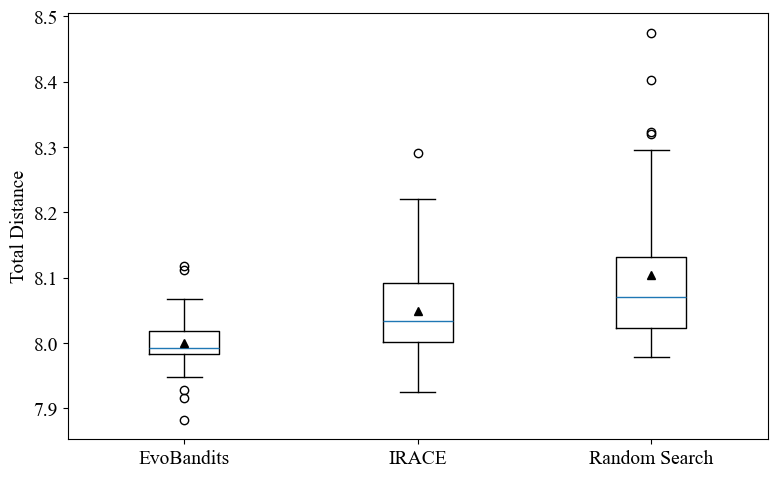

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.boxplot(
    mean_evaluation_data.values(), 
    tick_labels=mean_evaluation_data.keys(), 
    showmeans=True, 
    meanprops={"markerfacecolor":"black", "markeredgecolor":"black"}, 
    medianprops={"color": "C0"}
)
ax.set_ylabel("Total Distance")

plt.tight_layout()
plt.savefig(Path("_plots/06_comparison.pdf"))
plt.show()